# Shortcut Models

 One Step Diffusion via Shortcut Models, Frans et al., 2024. [[arXiv:2410.12557](https://arxiv.org/abs/2410.12557)]

## 1. Prepare Dataset

Define the gaussian mixture distribution as the target distribution.

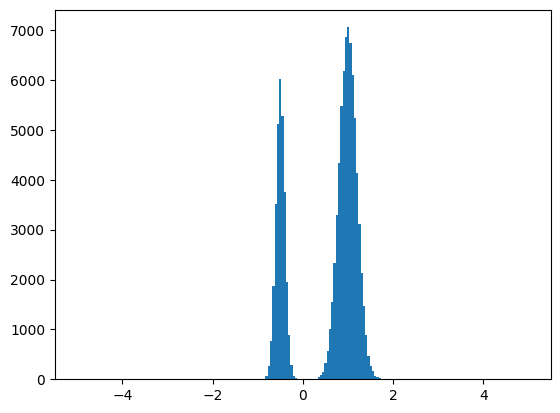

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as D

mixture = D.MixtureSameFamily(
    D.Categorical(torch.tensor([0.3, 0.7])),
    D.Normal(torch.tensor([-0.5, 1.0]), torch.tensor([0.1, 0.2])),
)
# target distribution
X = mixture.sample((100000, 1))

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

## 2. Define Model

Define MLP backbone and shortcut framework.

In [2]:
import torch
import torch.nn as nn

from flowmodels import ShortcutModel


class Backbone(nn.Module):
    def __init__(self, dim: int = 1, layers: int = 3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 2, 64),
            *[
                submodule
                for _ in range(layers)
                for submodule in (nn.ReLU(), nn.Linear(64, 64))
            ],
            nn.ReLU(),
            nn.Linear(64, dim),
        )

    def forward(
        self, x_t: torch.Tensor, t: torch.Tensor, d: torch.Tensor
    ) -> torch.Tensor:
        return self.net.forward(
            torch.cat([x_t, t[:, None].to(x_t), d[:, None].to(x_t)], dim=-1)
        )


model = ShortcutModel(Backbone())
model

ShortcutModel(
  (velocity_estim): Backbone(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## 3. Train Shortcut Model

Train the ODE model with the prepared dataset.

  0%|          | 0/1000 [00:00<?, ?it/s]

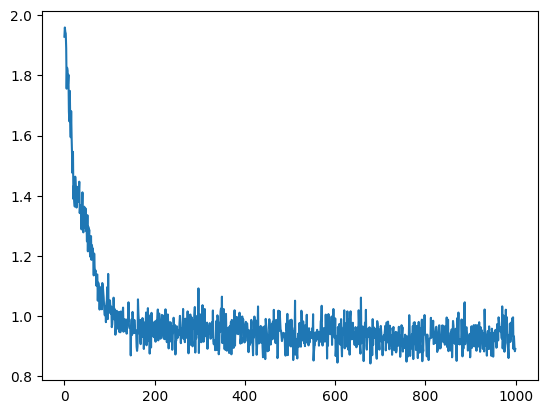

In [3]:
import torch
from tqdm.auto import tqdm

# training configurations
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        loss = model.loss(sample=X[torch.randint(0, len(X), (BATCH_SIZE,))])
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = loss.detach().item()
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")

plt.plot(losses)

## 4. Test the model

Sample from the model, inspect the trajectory.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

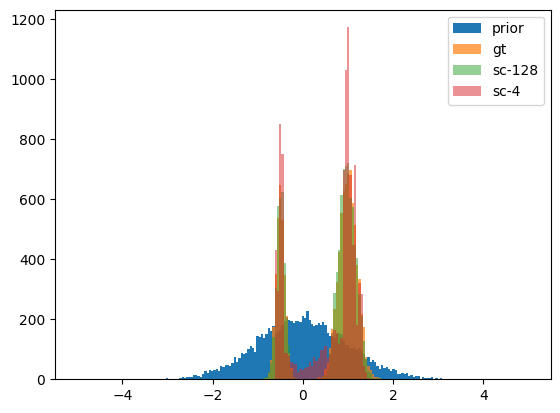

In [4]:
n = 10000
sample = torch.randn(n, X.shape[-1])
x_4, _ = model.sample(sample, verbose=lambda x: tqdm(x, leave=False), steps=1)
x_128, _ = model.sample(sample, verbose=lambda x: tqdm(x, leave=False), steps=128)

plt.hist(sample, bins=np.linspace(-5, 5, 200), label="prior")
plt.hist(X[:n], bins=np.linspace(-5, 5, 200), label="gt", alpha=0.7)
plt.hist(x_128.view(-1), bins=np.linspace(-5, 5, 200), label="sc-128", alpha=0.5)
plt.hist(x_4.view(-1), bins=np.linspace(-5, 5, 200), label="sc-4", alpha=0.5)
plt.legend()
_xticks, _ = plt.xticks()

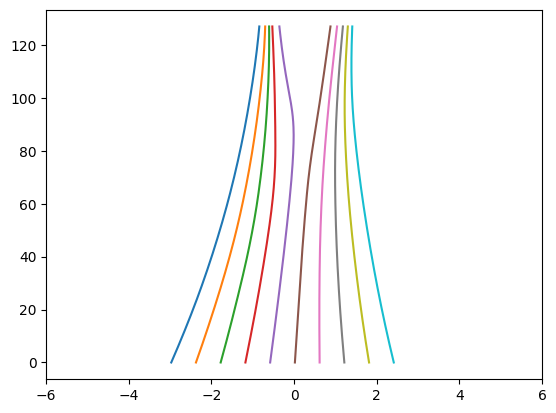

In [5]:
# Sampling trajectory
n = 200
x_t, x_ts = model.sample(torch.linspace(-3, 3, n)[:, None], steps=128)
for i in range(10):
    plt.plot(torch.tensor([_x_t[i * 20].item() for _x_t in x_ts]), range(len(x_ts)))
    plt.xticks(_xticks)